In [2]:
import scanpy as sc

train_adata = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/raw_datasets/differentiation/train_adata.h5ad')
val_adata = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/raw_datasets/differentiation/val_adata.h5ad')
test_adata = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/raw_datasets/differentiation/test_adata.h5ad')


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
train_adata = train_adata[train_adata.obs['day'].isin(['day0','day3'])]
train_adata.obs = train_adata.obs[['day']]


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
train_adata.obs['cell_type']='ipsc_diff'

In [5]:
train_adata.obs['day']

23794_3#285-day3    day3
25475_8#254-day3    day3
23794_3#316-day3    day3
24760_7#136-day3    day3
21554_2#19-day3     day3
                    ... 
24475_1#330-day0    day0
22139_6#36-day0     day0
24327_6#58-day0     day0
25271_8#190-day0    day0
24475_5#135-day0    day0
Name: day, Length: 2400, dtype: category
Categories (2, object): ['day3', 'day0']

In [6]:
import scanpy as sc
import scgen

In [7]:
scgen.SCGEN.setup_anndata(train_adata, batch_key="day", labels_key="cell_type")



In [16]:
model = scgen.SCGEN(train_adata)
model.save("/hpc/mydata/siyu.he/Siyu_projects/squidward_study/results/fig2/scgen_model_diff_prediction.pt", overwrite=True)

In [17]:
model.train(
    max_epochs=1000,
    batch_size=32,
    early_stopping=False,
    early_stopping_patience=25
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 54/1000:   5%|▌         | 53/1000 [00:31<09:19,  1.69it/s, v_num=1, train_loss_step=138, train_loss_epoch=117]

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [23]:
z_day0 = latent_adata[latent_adata.obs['day']=='day0'] 
z_day3 = latent_adata[latent_adata.obs['day']=='day3'] 

In [51]:
z_delta = z_day3.X.toarray().mean(axis=0) - z_day0.X.toarray().mean(axis=0)

In [94]:
import scipy
import torch
from sklearn.metrics import r2_score,r2_score
def cal_metric(x1,x2):
    r2 = r2_score(x1.detach().cpu().numpy().mean(axis=0),
                  x2.X.mean(axis=0))
    pearsonr,_ = scipy.stats.pearsonr(x1.detach().cpu().numpy().mean(axis=0),
                  x2.X.mean(axis=0))
    #print('r2=',r2)
    #print('pearsonr=',pearsonr)
    return r2, pearsonr

In [99]:
r_all = []
pearsonr_all = []
for i in range(6):
    test_day0_z = model.module.inference(torch.tensor(test_adata[test_adata.obs['day']=='day0'].X.toarray(),dtype=torch.float32))['z']
    test_day0_z = test_day0_z.detach().cpu()
    interp_z_day1 = test_day0_z+1/3*z_delta
    interp_z_day2 = test_day0_z+2/3*z_delta
    interp_z_day3 = test_day0_z+3/3*z_delta
    interp_day0 = model.module.generative(torch.tensor(test_day0_z))['px']
    interp_day1 = model.module.generative(torch.tensor(interp_z_day1))['px']
    interp_day2 = model.module.generative(torch.tensor(interp_z_day2))['px']
    interp_day3 = model.module.generative(torch.tensor(interp_z_day3))['px']
    
    r2_, pearsonr_ = cal_metric(interp_day0, test_adata[test_adata.obs['day']=='day0'])
    r_all.append(['scGen',i,'day0',r2_])
    pearsonr_all.append(['scGen',i,'day0',pearsonr_])
    r2_, pearsonr_ = cal_metric(interp_day1, test_adata[test_adata.obs['day']=='day1'])
    r_all.append(['scGen',i,'day1',r2_])
    pearsonr_all.append(['scGen',i,'day1',pearsonr_])
    r2_, pearsonr_ = cal_metric(interp_day2, test_adata[test_adata.obs['day']=='day2'])
    r_all.append(['scGen',i,'day2',r2_])
    pearsonr_all.append(['scGen',i,'day2',pearsonr_])
    r2_, pearsonr_ = cal_metric(interp_day3, test_adata[test_adata.obs['day']=='day3'])
    r_all.append(['scGen',i,'day3',r2_])
    pearsonr_all.append(['scGen',i,'day3',pearsonr_])

/tmp/ipykernel_3320730/2843306966.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interp_day0 = model.module.generative(torch.tensor(test_day0_z))['px']
/tmp/ipykernel_3320730/2843306966.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interp_day1 = model.module.generative(torch.tensor(interp_z_day1))['px']
/tmp/ipykernel_3320730/2843306966.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interp_day2 = model.module.generative(torch.tensor(interp_z_day2))['px']
/tmp/ipykernel_3320730/2843306966.py:12: UserWarning: To copy const

In [102]:
import pandas as pd
pd.DataFrame(r_all).to_csv('/hpc/mydata/siyu.he/squidward_study/results/fig2/scGen_r_all.csv')
pd.DataFrame(pearsonr_all).to_csv('/hpc/mydata/siyu.he/squidward_study/results/fig2/scGen_pearsonr_all.csv')


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# compare with squidiff

In [4]:
r_1 = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/results/fig2/scGen_r_all.csv',index_col = 0)
pearsonr_1 = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/results/fig2/scGen_pearsonr_all.csv',index_col = 0)
r_2 = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/results/fig2/squidiff_r_all.csv',index_col = 0)
pearsonr_2 = pd.read_csv('/hpc/mydata/siyu.he/Siyu_projects/squidward_study/results/fig2/squidiff_pearsonr_all.csv',index_col = 0)
r2_concat = pd.concat([r_1,r_2])
r2_concat.columns=['method','index','day','score']
pearsonr_concat = pd.concat([pearsonr_1,pearsonr_2])
pearsonr_concat.columns=['method','index','day','score']

0.9980620017548235
0.9999992122665892
0.8046193077938736
0.8247034986328486
0.8750823212187534
0.8950845949576435
0.9746583198392132
0.9968623219573204


([], [])

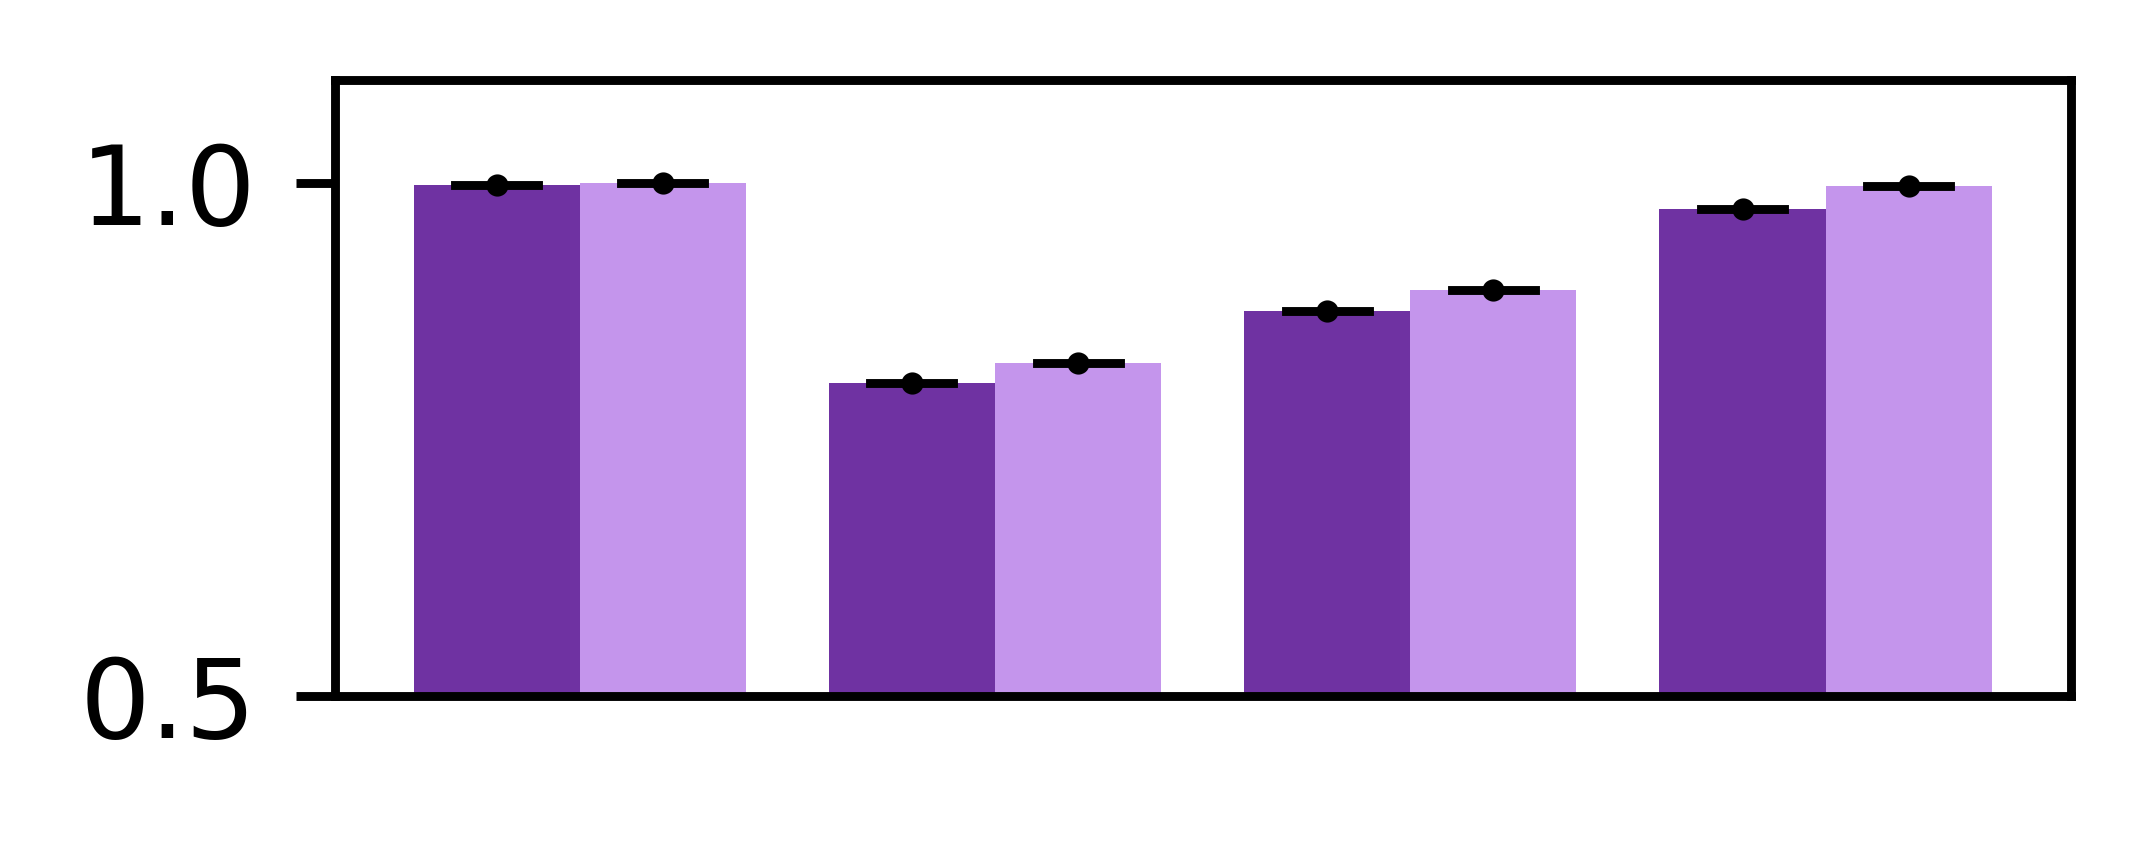

In [20]:
summary_df = pearsonr_concat.groupby(['day', 'method']).agg(
    score_mean=('score', 'mean'),
    score_se=('score', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

custom_palette = {'scGen': '#701fb5', 'squidiff': '#c587fa', }

fig, ax = plt.subplots(1, 1, figsize=(2.8, 1), dpi=800)

# Create the boxplot
sns.barplot(data=summary_df, x='day', y='score_mean', hue='method', 
            
            ax=ax, palette=custom_palette)
plt.ylim([0.5,1.1])
# Hide the legend
ax.legend_.remove()
# Add custom error bars
for i, row in summary_df.iterrows():
    # Calculate the position of the bar
    bar_pos = ax.get_xticks()[i // len(summary_df['method'].unique())]
    bar_width = ax.patches[i].get_width()
    bar_x = bar_pos + (i % len(summary_df['method'].unique())) * bar_width - bar_width / 2
    bar_y = row['score_mean']
    error = row['score_se']

    # Add the vertical line for the error bar
    print(bar_y)
    ax.plot([bar_x-0.1, bar_x+0.1], [bar_y , bar_y], color='black', linewidth=0.8)

    # Add the dot in the middle
    ax.plot(bar_x, bar_y, 'o', color='black', markersize=1)

# Change the color of the axes
axis_color = 'black'
ax.spines['top'].set_color(axis_color)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.spines['right'].set_color(axis_color)

# Change the color of the ticks
ax.tick_params(axis='x', colors=axis_color)
ax.tick_params(axis='y', colors=axis_color)

# Change the color of the labels (if they were present)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)

# Optional: additional formatting
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

In [25]:
r2_concat

,method,index,day,score
0,scGen,0,day0,0.994118
1,scGen,0,day1,0.564523
2,scGen,0,day2,0.665332
3,scGen,0,day3,0.905544
4,scGen,1,day0,0.994124
5,scGen,1,day1,0.564508
6,scGen,1,day2,0.665275
7,scGen,1,day3,0.905504
8,scGen,2,day0,0.994124
9,scGen,2,day1,0.564478


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

day1_scGen vs. day1_squidiff: t-test independent samples, P_val:1.554e-01 t=-1.537e+00
day0_scGen vs. day0_squidiff: t-test independent samples, P_val:3.974e-32 t=-3.795e+03
day2_scGen vs. day2_squidiff: t-test independent samples, P_val:3.926e-07 t=-1.163e+01
day3_scGen vs. day3_squidiff: t-test independent samples, P_val:7.222e-35 t=-7.133e+03


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Text(-19.097222222222214, 0.5, '')

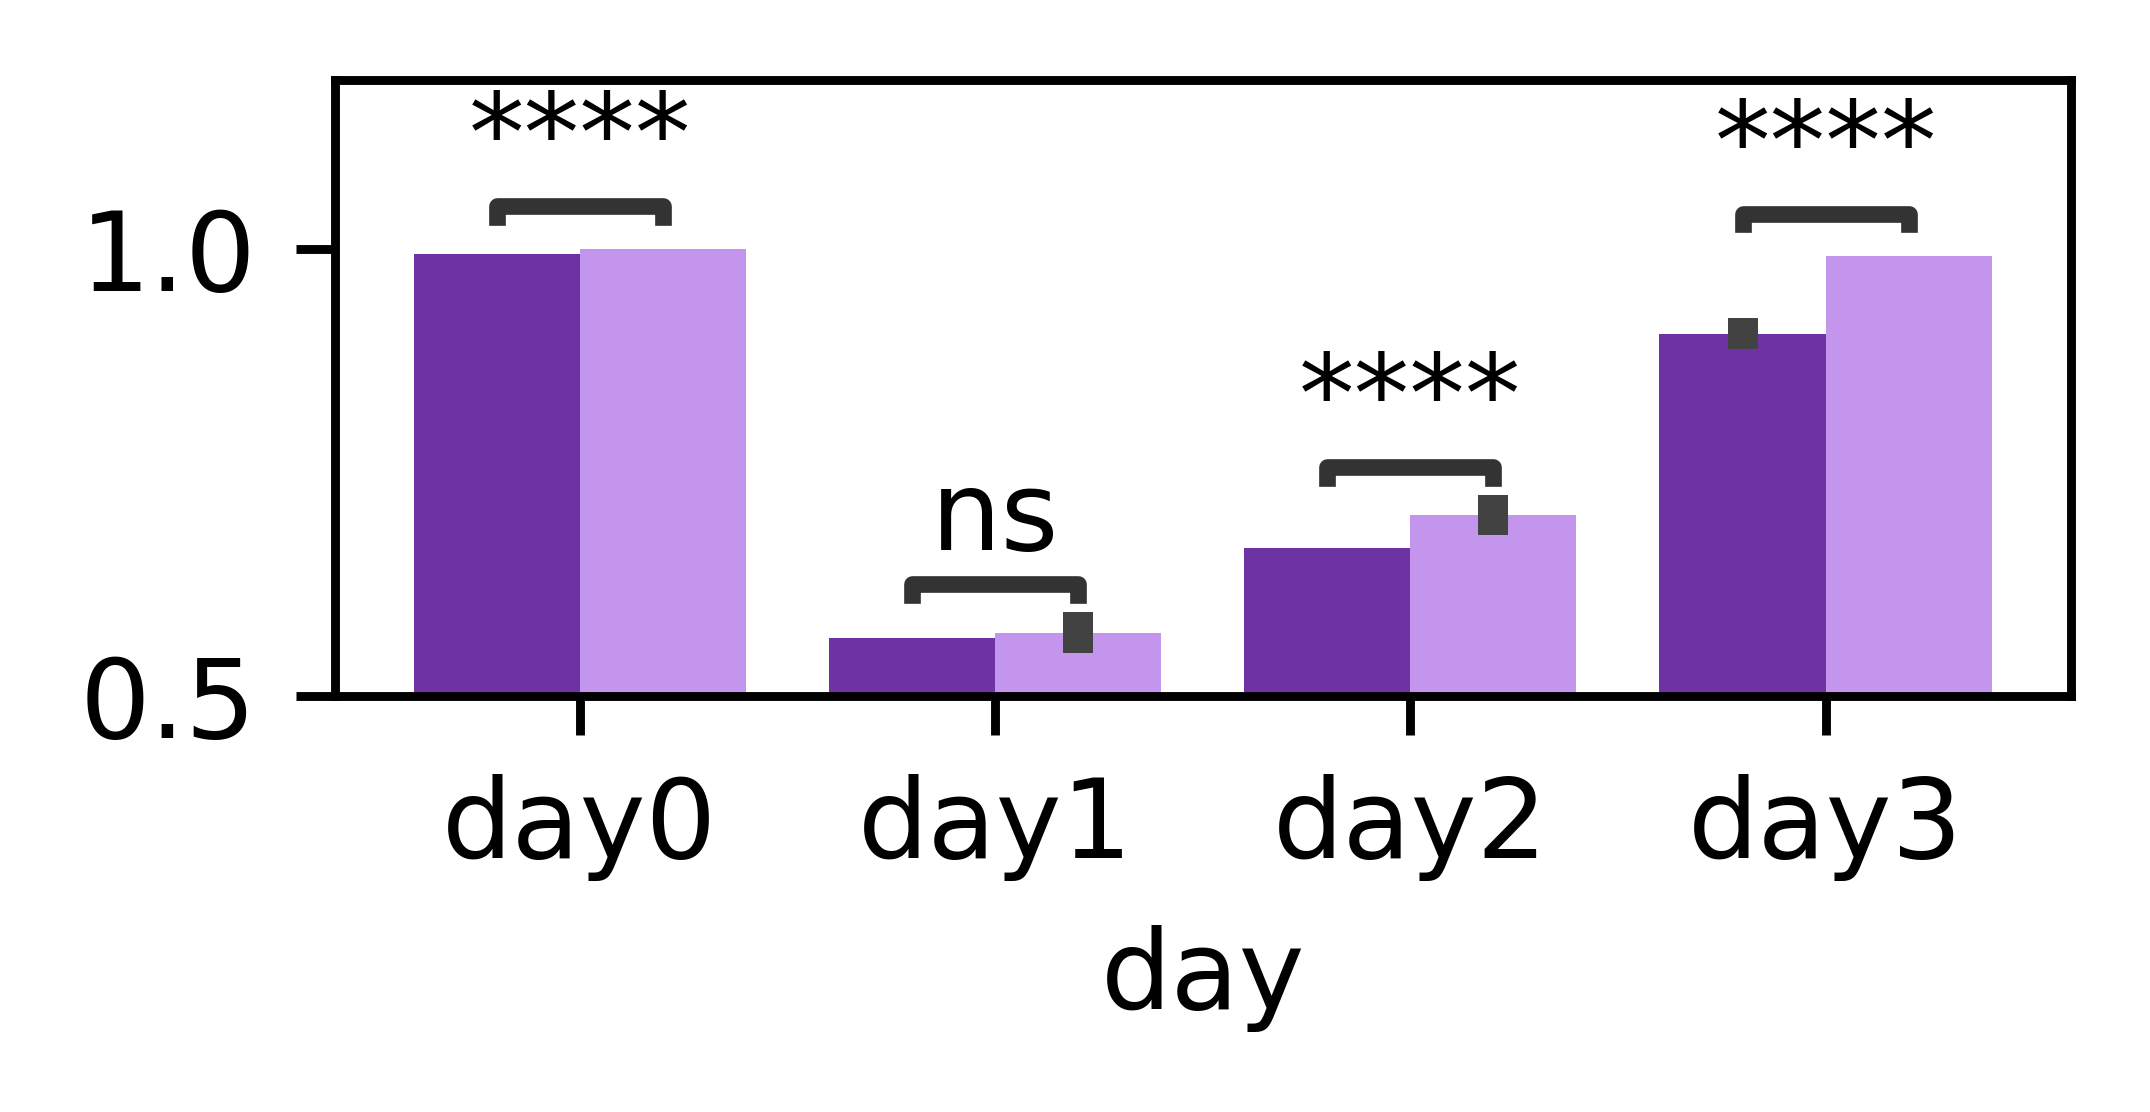

In [36]:
from statannotations.Annotator import Annotator

custom_palette = {'scGen': '#701fb5', 'squidiff': '#c587fa', 'method3': '#f5bf36', 'method4': '#fa2616'}

fig, ax = plt.subplots(1, 1, figsize=(2.8, 1), dpi=800)

# Create the boxplot
g1 = sns.barplot(data=r2_concat, x='day', y='score', hue='method', 
            
            ax=ax, palette=custom_palette)
#plt.ylim([0.75,1.1])
# Hide the legend
ax.legend_.remove()
plt.ylim([0.5,1.1])
box_pairs = [
             (('day0', 'scGen'), ('day0', 'squidiff')),
             (('day1', 'scGen'), ('day1', 'squidiff')),
             (('day2', 'scGen'), ('day2', 'squidiff')),
             (('day3', 'scGen'), ('day3', 'squidiff')),
            ]

annot = Annotator(g1, box_pairs, data=r2_concat, x='day', y='score', hue='method',alpha=0.5)
annot.configure(test='t-test_ind', verbose=2,text_format='star')
annot.apply_test(#equal_var=False,
                 #alternative='less'
                )
annot.annotate()
plt.ylabel('')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

day1_scGen vs. day1_squidiff: t-test independent samples, P_val:1.488e-09 t=-1.934e+01
day0_scGen vs. day0_squidiff: t-test independent samples, P_val:1.976e-35 t=-7.576e+03
day2_scGen vs. day2_squidiff: t-test independent samples, P_val:5.793e-07 t=-1.035e+01
day3_scGen vs. day3_squidiff: t-test independent samples, P_val:3.607e-33 t=-4.501e+03


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


([], [])

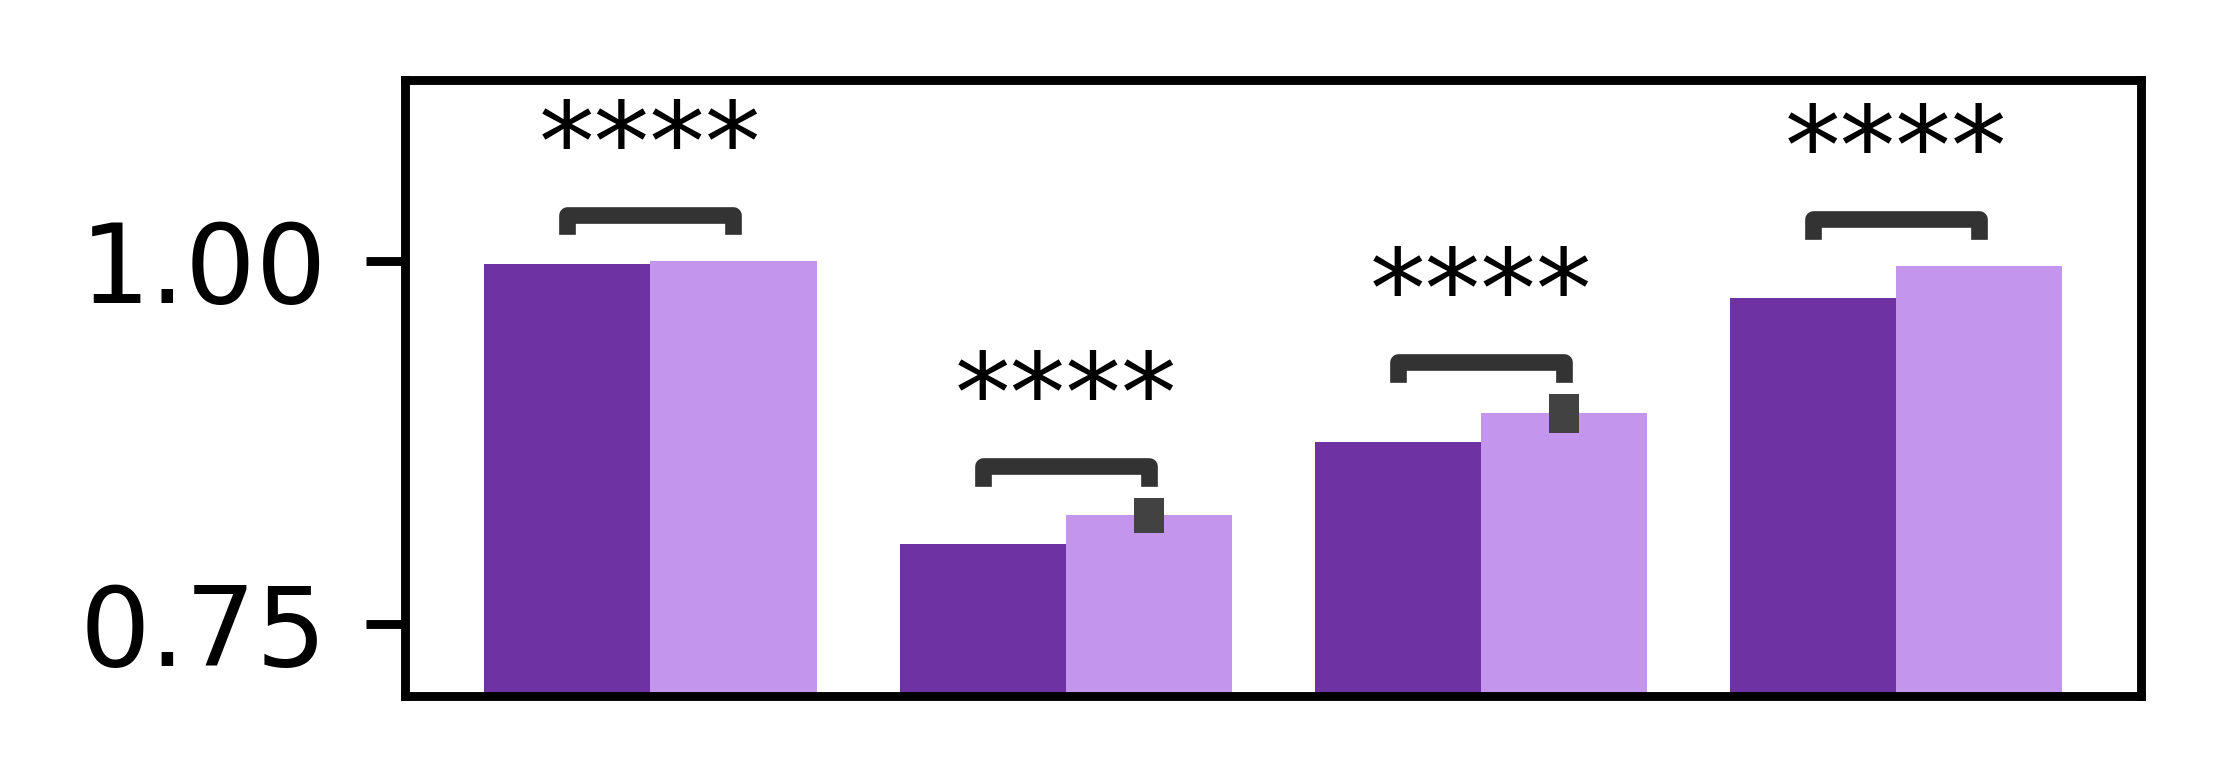

In [28]:
from statannotations.Annotator import Annotator

custom_palette = {'scGen': '#701fb5', 'squidiff': '#c587fa', 'method3': '#f5bf36', 'method4': '#fa2616'}

fig, ax = plt.subplots(1, 1, figsize=(2.8, 1), dpi=800)

# Create the boxplot
g1 = sns.barplot(data=pearsonr_concat, x='day', y='score', hue='method', 
            
            ax=ax, palette=custom_palette)
plt.ylim([0.75,1.1])
# Hide the legend
ax.legend_.remove()

box_pairs = [
             (('day0', 'scGen'), ('day0', 'squidiff')),
             (('day1', 'scGen'), ('day1', 'squidiff')),
             (('day2', 'scGen'), ('day2', 'squidiff')),
             (('day3', 'scGen'), ('day3', 'squidiff')),
            ]

annot = Annotator(g1, box_pairs, data=pearsonr_concat, x='day', y='score', hue='method',alpha=0.5)
annot.configure(test='t-test_ind', verbose=2,text_format='star')
annot.apply_test(#equal_var=False,
                 alternative='less'
                )
annot.annotate()

# Optional: additional formatting
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

0.9941228644911937
0.999988588400092
0.5644933133672532
0.5701946899949456
0.6652908415851372
0.7020709480134252
0.9055201707724132
0.9917620379521699


([], [])

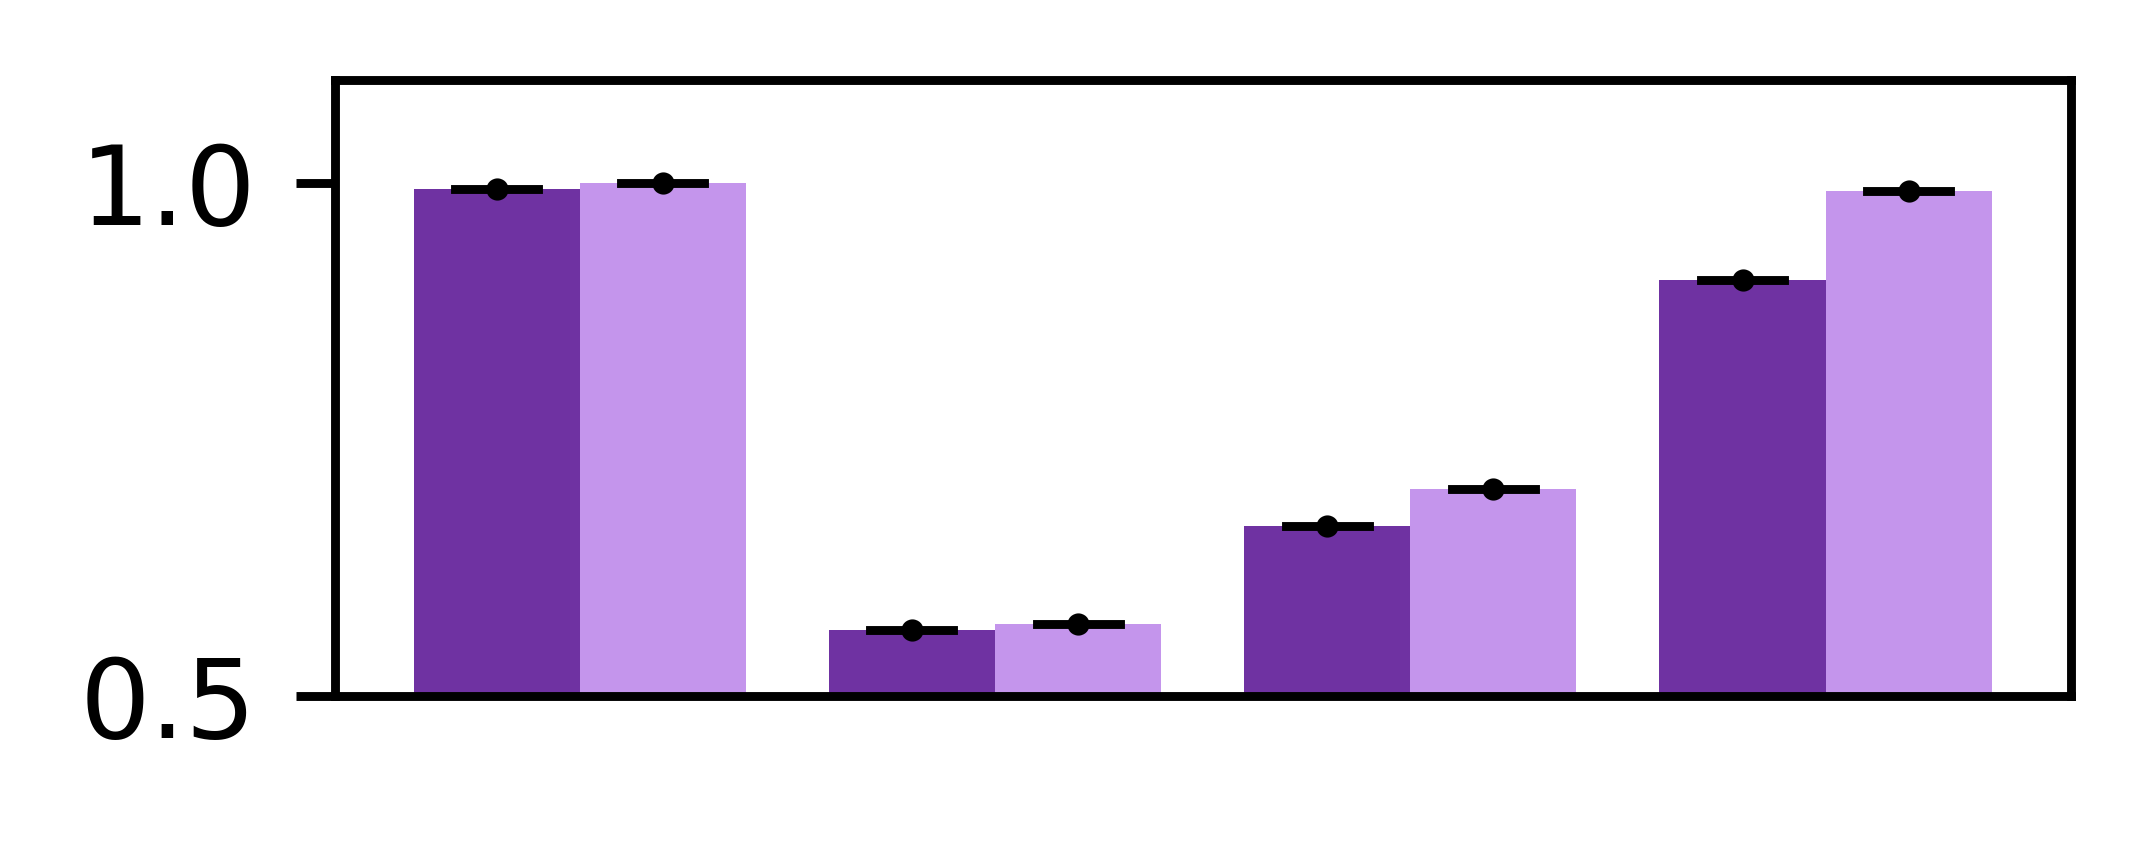

In [19]:
summary_df = r2_concat.groupby(['day', 'method']).agg(
    score_mean=('score', 'mean'),
    score_se=('score', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

custom_palette = {'scGen': '#701fb5', 'squidiff': '#c587fa', }

fig, ax = plt.subplots(1, 1, figsize=(2.8, 1), dpi=800)

# Create the boxplot
sns.barplot(data=summary_df, x='day', y='score_mean', hue='method', 
            
            ax=ax, palette=custom_palette)
plt.ylim([0.5,1.1])
# Hide the legend
ax.legend_.remove()
# Add custom error bars
for i, row in summary_df.iterrows():
    # Calculate the position of the bar
    bar_pos = ax.get_xticks()[i // len(summary_df['method'].unique())]
    bar_width = ax.patches[i].get_width()
    bar_x = bar_pos + (i % len(summary_df['method'].unique())) * bar_width - bar_width / 2
    bar_y = row['score_mean']
    error = row['score_se']

    # Add the vertical line for the error bar
    print(bar_y)
    ax.plot([bar_x-0.1, bar_x+0.1], [bar_y , bar_y], color='black', linewidth=0.8)

    # Add the dot in the middle
    ax.plot(bar_x, bar_y, 'o', color='black', markersize=1)

# Change the color of the axes
axis_color = 'black'
ax.spines['top'].set_color(axis_color)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.spines['right'].set_color(axis_color)

# Change the color of the ticks
ax.tick_params(axis='x', colors=axis_color)
ax.tick_params(axis='y', colors=axis_color)

# Change the color of the labels (if they were present)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)

# Optional: additional formatting
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

In [103]:
import numpy as np
import anndata
combined_labels  = np.array([0]*600+[1]*600+[2]*600+[3]*600)
pred_tensor =np.array( torch.cat([interp_day0,interp_day1,interp_day2,interp_day3], dim=0).detach().cpu())
all_new_data = anndata.AnnData(pred_tensor)
all_new_data.obs['weights'] = combined_labels
all_new_data.obs['weights'] = all_new_data.obs['weights'].astype(str).astype('category')
all_new_data.var_names = test_adata.var_names
all_new_data.obs.groupby('weights').mean()

/tmp/ipykernel_3320730/3147284389.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_new_data.obs.groupby('weights').mean()


""
weights
0
1
2
3


In [104]:
import scanpy as sc
sc.tl.rank_genes_groups(all_new_data, groupby='weights', method='wilcoxon')
all_new_data.layers['scaled'] = sc.pp.scale(all_new_data, copy=True).X
marker_genes_dict = {
    '0.0': ['T', 'GATA6','NANOG'],
}

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


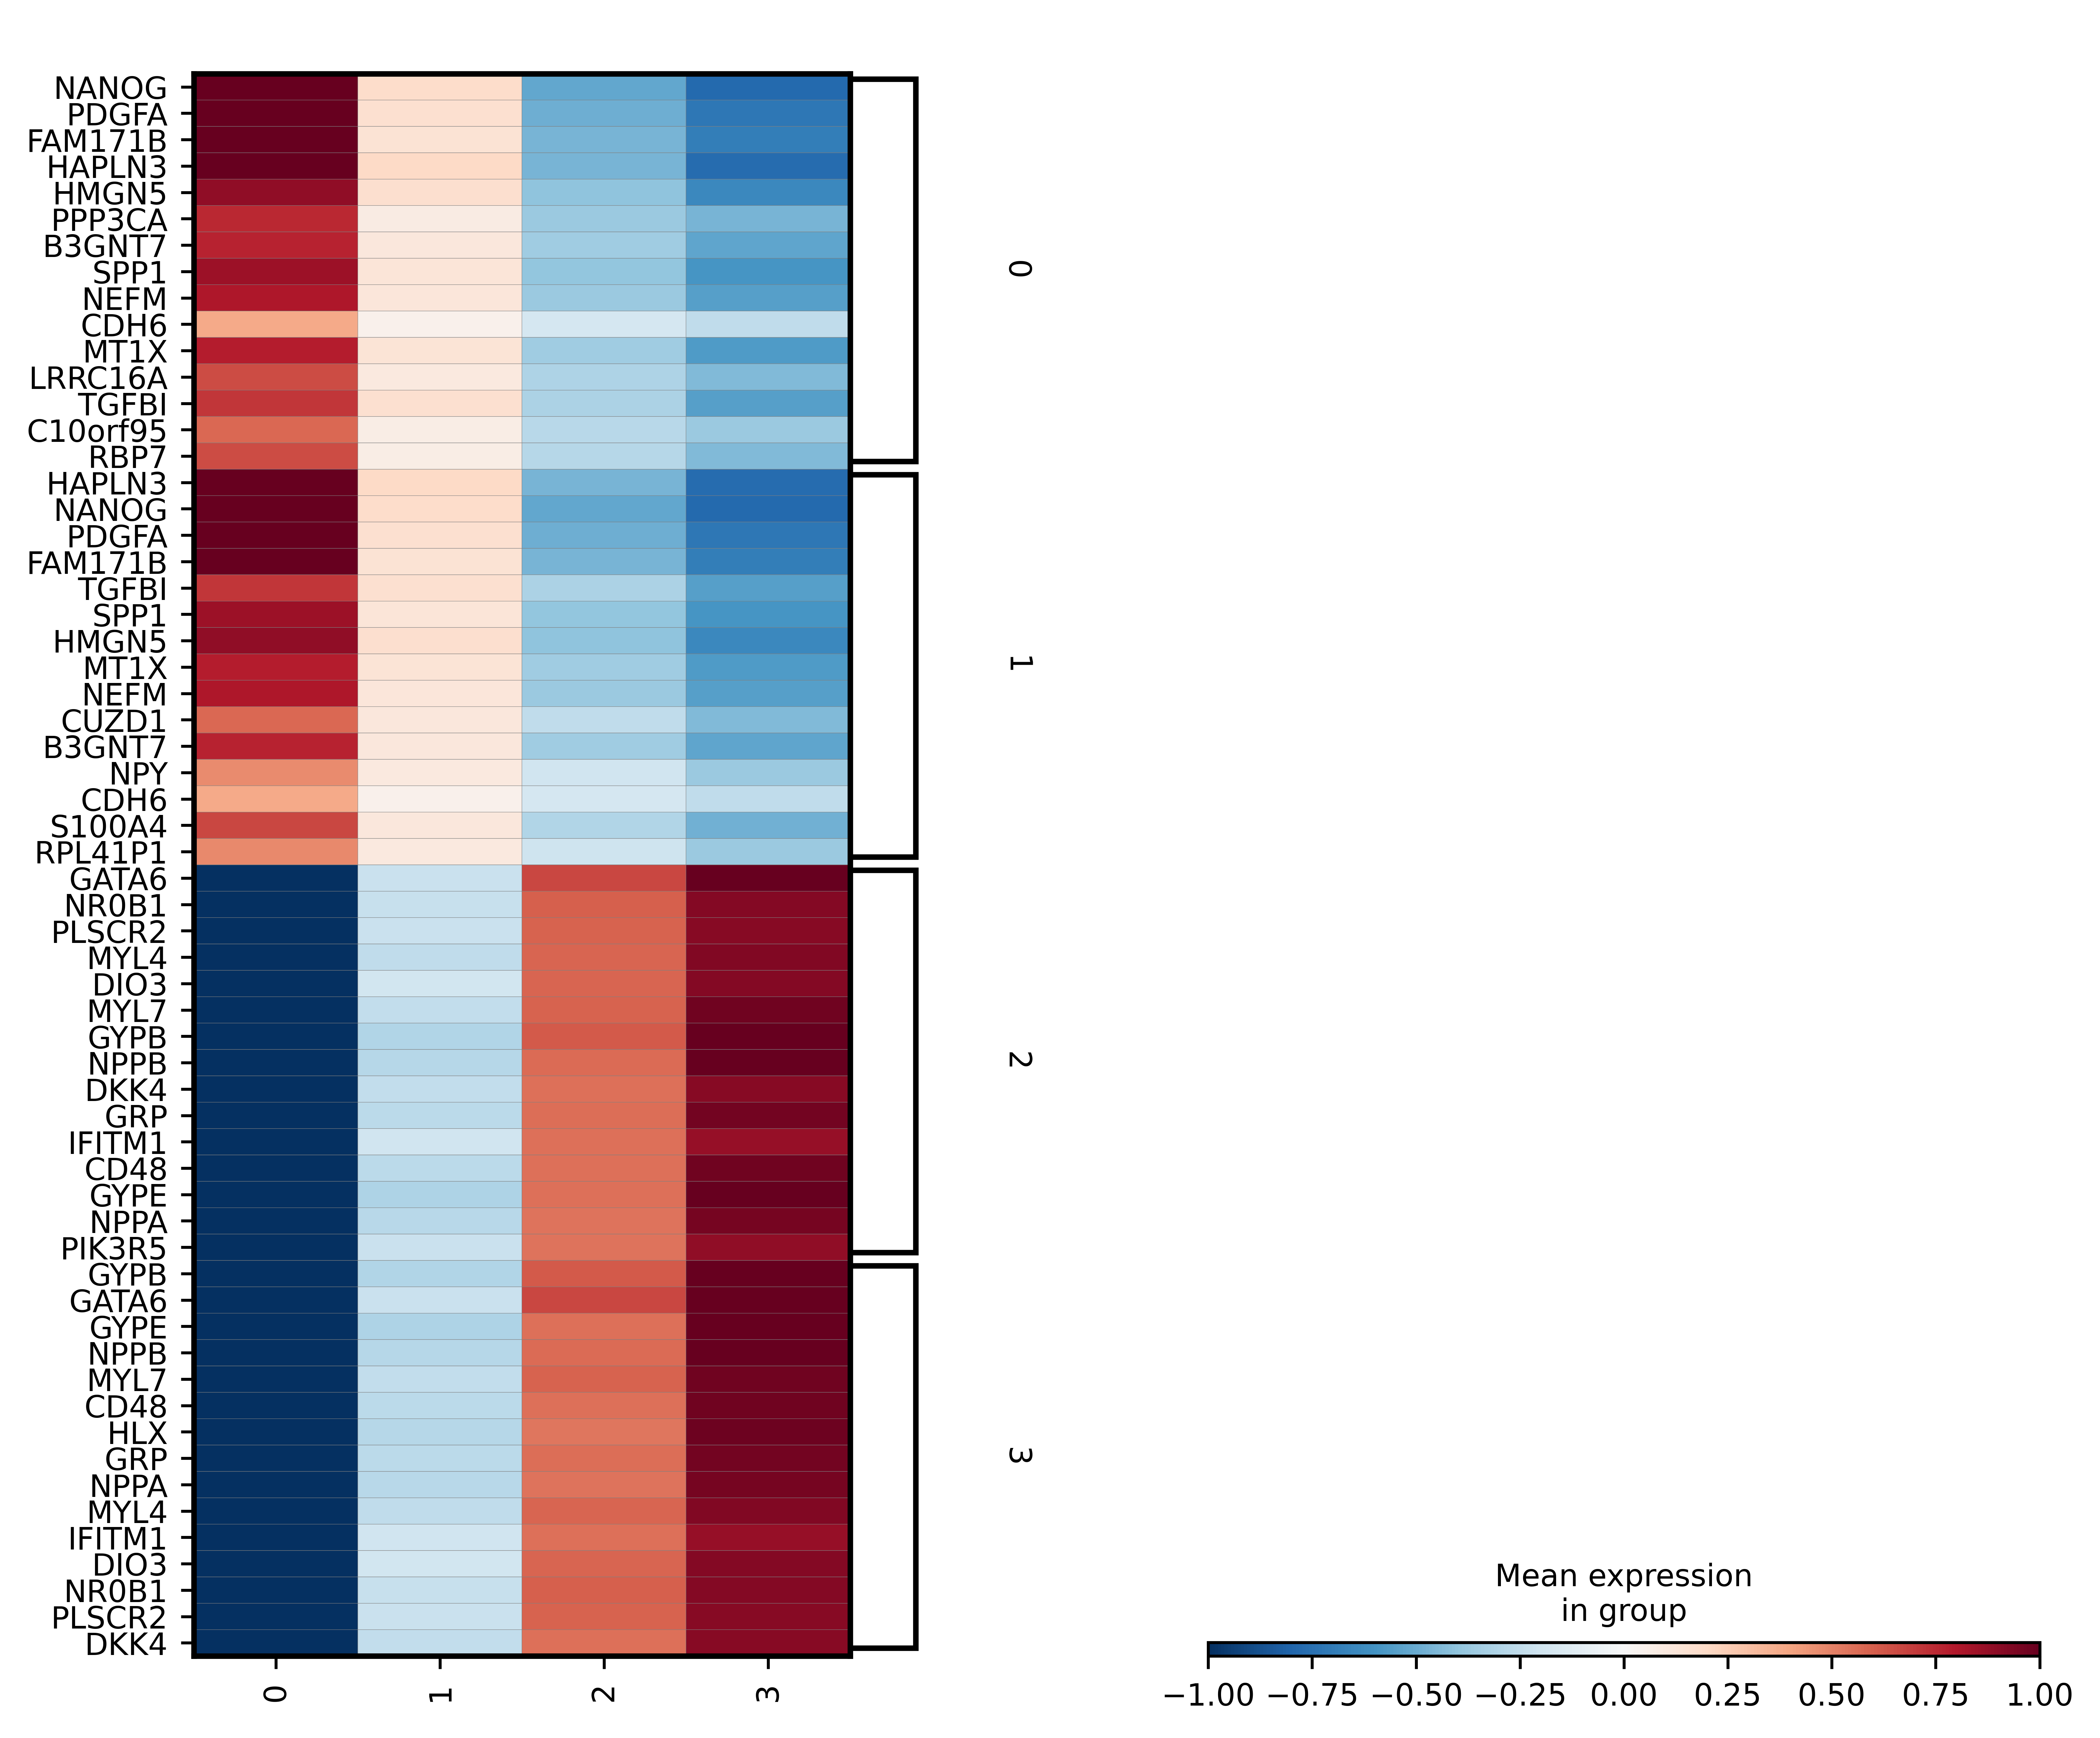

In [105]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize =(9,8),dpi=800)
sc.pl.rank_genes_groups_matrixplot(all_new_data, 
                                dendrogram=False,
                                n_genes=15, 
                                   use_raw=False, 
                                swap_axes=True, 
                                vmin=-1, vmax=1, 
                                cmap='RdBu_r', 
                                layer='scaled', 
                                   ax=ax,
                                show=False);

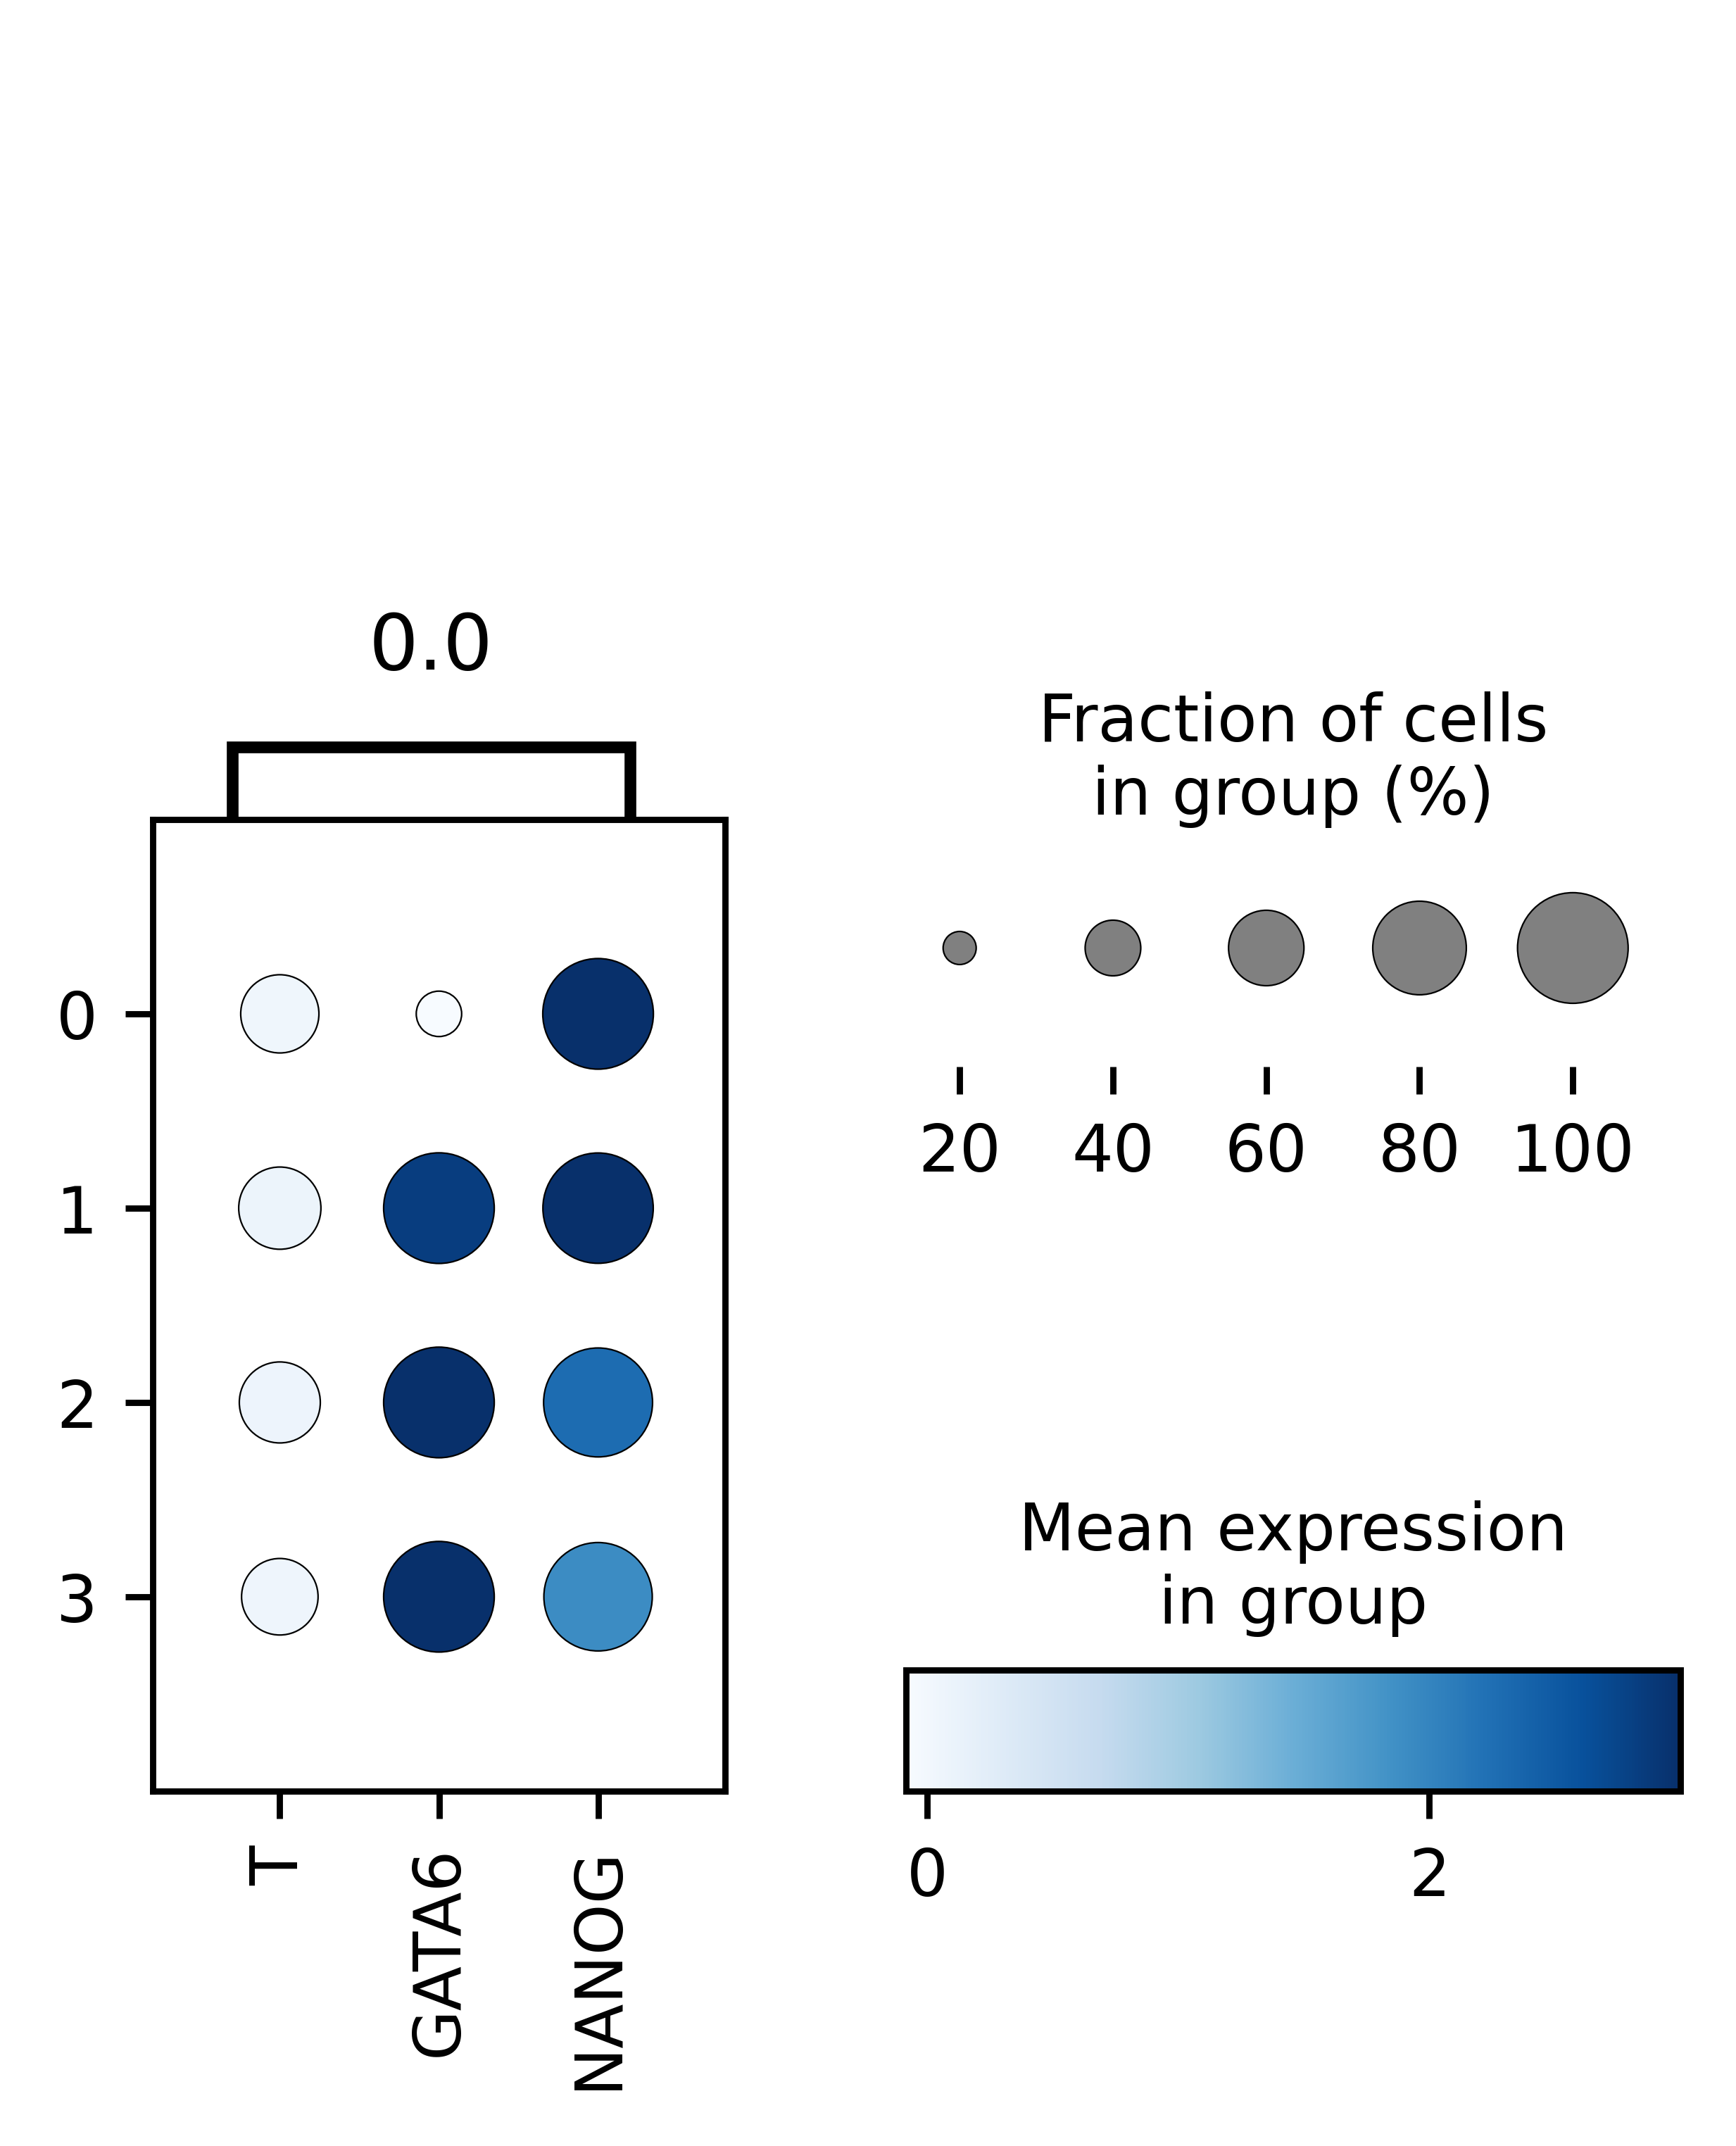

In [106]:
fig,ax = plt.subplots(figsize =(3.5,4),dpi=800)
sc.pl.dotplot(all_new_data, 
              marker_genes_dict, 'weights', 
              vmax=3,
              dendrogram=False,
              ax=ax,
              cmap='Blues'
             )